In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Net(nn.Module):
    def __init__(self , model):	#此处的model参数是已经加载了预训练参数的模型，方便继承预训练成果
        super(Net, self).__init__()
        #取掉model的后两层
        self.resnet_layer = nn.Sequential(*list(model.children())[:-2])
        self.dr_layer1=nn.modules.conv.Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn1=nn.modules.batchnorm.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer2=nn.modules.conv.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn2=nn.modules.batchnorm.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer3=nn.modules.conv.Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn3=nn.modules.batchnorm.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer4=nn.modules.conv.Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

        
    def forward(self, x):
        x = self.resnet_layer(x)
        x=self.dr_layer1(x)
        x=self.dr_bn1(x)
        x=self.dr_layer2(x)
        x=self.dr_bn2(x)
        x=self.dr_layer3(x)
        x=self.dr_bn3(x)
        x=self.dr_layer4(x)
        return x

In [3]:
resnet50 = models.resnet50(pretrained=True)
resnet50.conv1=nn.modules.conv.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = Net(resnet50) 
model=model.to(device)
# print(model)

In [4]:
shapeness1=np.load('/home/chase/Boyka/Lyu/data/shapeness/origin/rainfall_img256_sharpness16_unit8.npz')
data=shapeness1['data'][:,-1]
label=shapeness1['rainfall']
# data=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/data_reg_2000.npy')
data=np.expand_dims(data,axis=1)
# data=torch.from_numpy(data)
data=torch.FloatTensor(data)
# print(type(data[0][0][0]))
# print(data[0][0][0])
# label=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/label_reg_2000.npy')
print(label.shape)
label=np.expand_dims(label,axis=1)
# label=torch.from_numpy(label)
label=torch.FloatTensor(label)
# print(label[0][0][0])
# print(data.shape,label.shape)
train_x=data[:-20]
test_x=data[-20:]
train_y=label[:-20]
test_y=label[-20:]
print(data.shape,label.shape)

(100, 8, 8)
torch.Size([100, 1, 256, 256]) torch.Size([100, 1, 8, 8])


In [5]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [6]:
for epoch in range(1):
    for i,data in enumerate(train_loader):
        inputs, label=data
#         print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())
        print(len(data))
        print(data[0].shape)
        print(inputs.shape)
        print(label.shape)
        print(type(data[0][0][0][0]))
        break
        
        

2
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 8, 8])
<class 'torch.Tensor'>


In [7]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    
    history = []
    best_error = float('inf')
    best_epoch = 0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_error = 0.0
        valid_loss = 0.0
        valid_error = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += torch.mean(loss).item() 
            
            train_error+=torch.mean(torch.abs(outputs-labels)).item()
 
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                valid_loss += torch.mean(loss).item() 
                
                valid_error+=torch.mean(torch.abs(outputs-labels)).item()
 
 
        avg_train_loss = train_loss/train_data_size
        avg_train_error = train_error/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_error = valid_error/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_error, avg_valid_error])
 
        if best_error > avg_valid_error:
            best_error = avg_valid_error
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Training: Loss: {:.4f}, MAE: {:.4f}, \nValidation: Loss: {:.4f}, MAE: {:.4f}, \nTime: {:.4f}s".format(avg_train_loss, avg_train_error, avg_valid_loss, avg_valid_error, epoch_end-epoch_start
        ))
        print("Best Error for validation : {:.4f} at epoch {:03d}".format(best_error, best_epoch))
 
        torch.save(model, 'models/'+'rivers_model_'+str(epoch+1)+'.pt')
    return model, history


In [8]:
loss_func=nn.MSELoss()
num_epochs=500
optimizer = optim.Adam(model.parameters())


trained_model, history = train_and_valid(model, loss_func, optimizer, num_epochs)
torch.save(trained_model, 'models/'+'best_model.pt')
 


Epoch: 1/500


/home/chase/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: Loss: 0.4334, MAE: 0.5533, 
Validation: Loss: 6.0288, MAE: 2.3473, 
Time: 1.1827s
Best Error for validation : 2.3473 at epoch 001
Epoch: 2/500
Training: Loss: 0.3261, MAE: 0.4997, 
Validation: Loss: 5.5808, MAE: 2.1498, 
Time: 1.1876s
Best Error for validation : 2.1498 at epoch 002
Epoch: 3/500
Training: Loss: 0.3136, MAE: 0.4963, 
Validation: Loss: 2.5218, MAE: 1.4177, 
Time: 1.1875s
Best Error for validation : 1.4177 at epoch 003
Epoch: 4/500
Training: Loss: 0.2996, MAE: 0.4905, 
Validation: Loss: 1.6122, MAE: 1.1941, 
Time: 1.1866s
Best Error for validation : 1.1941 at epoch 004
Epoch: 5/500
Training: Loss: 0.2938, MAE: 0.4919, 
Validation: Loss: 1.1174, MAE: 1.0109, 
Time: 1.1847s
Best Error for validation : 1.0109 at epoch 005
Epoch: 6/500
Training: Loss: 0.2814, MAE: 0.4874, 
Validation: Loss: 0.7677, MAE: 0.8311, 
Time: 1.1811s
Best Error for validation : 0.8311 at epoch 006
Epoch: 7/500
Training: Loss: 0.2716, MAE: 0.4857, 
Validation: Loss: 0.5327, MAE: 0.6854, 
Time

Epoch: 55/500
Training: Loss: 0.0352, MAE: 0.1861, 
Validation: Loss: 0.0714, MAE: 0.2221, 
Time: 1.1836s
Best Error for validation : 0.2221 at epoch 055
Epoch: 56/500
Training: Loss: 0.0311, MAE: 0.1752, 
Validation: Loss: 0.0688, MAE: 0.2158, 
Time: 1.1861s
Best Error for validation : 0.2158 at epoch 056
Epoch: 57/500
Training: Loss: 0.0279, MAE: 0.1657, 
Validation: Loss: 0.0657, MAE: 0.2114, 
Time: 1.1896s
Best Error for validation : 0.2114 at epoch 057
Epoch: 58/500
Training: Loss: 0.0259, MAE: 0.1600, 
Validation: Loss: 0.0631, MAE: 0.2057, 
Time: 1.1874s
Best Error for validation : 0.2057 at epoch 058
Epoch: 59/500
Training: Loss: 0.0228, MAE: 0.1502, 
Validation: Loss: 0.0614, MAE: 0.2052, 
Time: 1.1872s
Best Error for validation : 0.2052 at epoch 059
Epoch: 60/500
Training: Loss: 0.0208, MAE: 0.1424, 
Validation: Loss: 0.0580, MAE: 0.1932, 
Time: 1.1855s
Best Error for validation : 0.1932 at epoch 060
Epoch: 61/500
Training: Loss: 0.0185, MAE: 0.1339, 
Validation: Loss: 0.0568

Epoch: 109/500
Training: Loss: 0.0005, MAE: 0.0162, 
Validation: Loss: 0.0393, MAE: 0.1525, 
Time: 1.1919s
Best Error for validation : 0.1519 at epoch 095
Epoch: 110/500
Training: Loss: 0.0007, MAE: 0.0196, 
Validation: Loss: 0.0394, MAE: 0.1539, 
Time: 1.1887s
Best Error for validation : 0.1519 at epoch 095
Epoch: 111/500
Training: Loss: 0.0007, MAE: 0.0197, 
Validation: Loss: 0.0393, MAE: 0.1520, 
Time: 1.1883s
Best Error for validation : 0.1519 at epoch 095
Epoch: 112/500
Training: Loss: 0.0006, MAE: 0.0177, 
Validation: Loss: 0.0388, MAE: 0.1525, 
Time: 1.1828s
Best Error for validation : 0.1519 at epoch 095
Epoch: 113/500
Training: Loss: 0.0005, MAE: 0.0174, 
Validation: Loss: 0.0389, MAE: 0.1516, 
Time: 1.1859s
Best Error for validation : 0.1516 at epoch 113
Epoch: 114/500
Training: Loss: 0.0005, MAE: 0.0170, 
Validation: Loss: 0.0388, MAE: 0.1523, 
Time: 1.1853s
Best Error for validation : 0.1516 at epoch 113
Epoch: 115/500
Training: Loss: 0.0005, MAE: 0.0173, 
Validation: Loss:

Epoch: 162/500
Training: Loss: 0.0002, MAE: 0.0099, 
Validation: Loss: 0.0383, MAE: 0.1511, 
Time: 1.1893s
Best Error for validation : 0.1505 at epoch 148
Epoch: 163/500
Training: Loss: 0.0002, MAE: 0.0127, 
Validation: Loss: 0.0385, MAE: 0.1515, 
Time: 1.1852s
Best Error for validation : 0.1505 at epoch 148
Epoch: 164/500
Training: Loss: 0.0002, MAE: 0.0115, 
Validation: Loss: 0.0381, MAE: 0.1505, 
Time: 1.1834s
Best Error for validation : 0.1505 at epoch 164
Epoch: 165/500
Training: Loss: 0.0002, MAE: 0.0098, 
Validation: Loss: 0.0382, MAE: 0.1510, 
Time: 1.1881s
Best Error for validation : 0.1505 at epoch 164
Epoch: 166/500
Training: Loss: 0.0001, MAE: 0.0085, 
Validation: Loss: 0.0382, MAE: 0.1504, 
Time: 1.1869s
Best Error for validation : 0.1504 at epoch 166
Epoch: 167/500
Training: Loss: 0.0001, MAE: 0.0092, 
Validation: Loss: 0.0381, MAE: 0.1506, 
Time: 1.1859s
Best Error for validation : 0.1504 at epoch 166
Epoch: 168/500
Training: Loss: 0.0001, MAE: 0.0091, 
Validation: Loss:

Epoch: 215/500
Training: Loss: 0.0001, MAE: 0.0092, 
Validation: Loss: 0.0377, MAE: 0.1498, 
Time: 1.1875s
Best Error for validation : 0.1498 at epoch 215
Epoch: 216/500
Training: Loss: 0.0001, MAE: 0.0094, 
Validation: Loss: 0.0382, MAE: 0.1508, 
Time: 1.1899s
Best Error for validation : 0.1498 at epoch 215
Epoch: 217/500
Training: Loss: 0.0002, MAE: 0.0122, 
Validation: Loss: 0.0378, MAE: 0.1501, 
Time: 1.1877s
Best Error for validation : 0.1498 at epoch 215
Epoch: 218/500
Training: Loss: 0.0002, MAE: 0.0123, 
Validation: Loss: 0.0380, MAE: 0.1505, 
Time: 1.1882s
Best Error for validation : 0.1498 at epoch 215
Epoch: 219/500
Training: Loss: 0.0002, MAE: 0.0113, 
Validation: Loss: 0.0377, MAE: 0.1500, 
Time: 1.1874s
Best Error for validation : 0.1498 at epoch 215
Epoch: 220/500
Training: Loss: 0.0002, MAE: 0.0107, 
Validation: Loss: 0.0380, MAE: 0.1503, 
Time: 1.1850s
Best Error for validation : 0.1498 at epoch 215
Epoch: 221/500
Training: Loss: 0.0001, MAE: 0.0091, 
Validation: Loss:

Epoch: 268/500
Training: Loss: 0.0002, MAE: 0.0096, 
Validation: Loss: 0.0375, MAE: 0.1498, 
Time: 1.1785s
Best Error for validation : 0.1495 at epoch 250
Epoch: 269/500
Training: Loss: 0.0002, MAE: 0.0100, 
Validation: Loss: 0.0376, MAE: 0.1497, 
Time: 1.1734s
Best Error for validation : 0.1495 at epoch 250
Epoch: 270/500
Training: Loss: 0.0001, MAE: 0.0098, 
Validation: Loss: 0.0375, MAE: 0.1494, 
Time: 1.1865s
Best Error for validation : 0.1494 at epoch 270
Epoch: 271/500
Training: Loss: 0.0002, MAE: 0.0101, 
Validation: Loss: 0.0378, MAE: 0.1502, 
Time: 1.1877s
Best Error for validation : 0.1494 at epoch 270
Epoch: 272/500
Training: Loss: 0.0002, MAE: 0.0117, 
Validation: Loss: 0.0376, MAE: 0.1496, 
Time: 1.1889s
Best Error for validation : 0.1494 at epoch 270
Epoch: 273/500
Training: Loss: 0.0002, MAE: 0.0099, 
Validation: Loss: 0.0376, MAE: 0.1499, 
Time: 1.1873s
Best Error for validation : 0.1494 at epoch 270
Epoch: 274/500
Training: Loss: 0.0002, MAE: 0.0100, 
Validation: Loss:

Epoch: 321/500
Training: Loss: 0.0001, MAE: 0.0069, 
Validation: Loss: 0.0374, MAE: 0.1494, 
Time: 1.1873s
Best Error for validation : 0.1491 at epoch 308
Epoch: 322/500
Training: Loss: 0.0001, MAE: 0.0070, 
Validation: Loss: 0.0375, MAE: 0.1495, 
Time: 1.1868s
Best Error for validation : 0.1491 at epoch 308
Epoch: 323/500
Training: Loss: 0.0002, MAE: 0.0115, 
Validation: Loss: 0.0375, MAE: 0.1494, 
Time: 1.1845s
Best Error for validation : 0.1491 at epoch 308
Epoch: 324/500
Training: Loss: 0.0001, MAE: 0.0061, 
Validation: Loss: 0.0375, MAE: 0.1493, 
Time: 1.1909s
Best Error for validation : 0.1491 at epoch 308
Epoch: 325/500
Training: Loss: 0.0001, MAE: 0.0077, 
Validation: Loss: 0.0374, MAE: 0.1492, 
Time: 1.1903s
Best Error for validation : 0.1491 at epoch 308
Epoch: 326/500
Training: Loss: 0.0001, MAE: 0.0086, 
Validation: Loss: 0.0377, MAE: 0.1499, 
Time: 1.1893s
Best Error for validation : 0.1491 at epoch 308
Epoch: 327/500
Training: Loss: 0.0001, MAE: 0.0091, 
Validation: Loss:

Epoch: 374/500
Training: Loss: 0.0001, MAE: 0.0082, 
Validation: Loss: 0.0376, MAE: 0.1499, 
Time: 1.1898s
Best Error for validation : 0.1491 at epoch 373
Epoch: 375/500
Training: Loss: 0.0001, MAE: 0.0089, 
Validation: Loss: 0.0374, MAE: 0.1494, 
Time: 1.1890s
Best Error for validation : 0.1491 at epoch 373
Epoch: 376/500
Training: Loss: 0.0001, MAE: 0.0073, 
Validation: Loss: 0.0375, MAE: 0.1500, 
Time: 1.1853s
Best Error for validation : 0.1491 at epoch 373
Epoch: 377/500
Training: Loss: 0.0001, MAE: 0.0090, 
Validation: Loss: 0.0373, MAE: 0.1495, 
Time: 1.1883s
Best Error for validation : 0.1491 at epoch 373
Epoch: 378/500
Training: Loss: 0.0001, MAE: 0.0086, 
Validation: Loss: 0.0374, MAE: 0.1499, 
Time: 1.1857s
Best Error for validation : 0.1491 at epoch 373
Epoch: 379/500
Training: Loss: 0.0001, MAE: 0.0093, 
Validation: Loss: 0.0374, MAE: 0.1496, 
Time: 1.1904s
Best Error for validation : 0.1491 at epoch 373
Epoch: 380/500
Training: Loss: 0.0002, MAE: 0.0103, 
Validation: Loss:

Epoch: 427/500
Training: Loss: 0.0001, MAE: 0.0092, 
Validation: Loss: 0.0372, MAE: 0.1490, 
Time: 1.1897s
Best Error for validation : 0.1489 at epoch 420
Epoch: 428/500
Training: Loss: 0.0001, MAE: 0.0077, 
Validation: Loss: 0.0373, MAE: 0.1493, 
Time: 1.1864s
Best Error for validation : 0.1489 at epoch 420
Epoch: 429/500
Training: Loss: 0.0001, MAE: 0.0058, 
Validation: Loss: 0.0371, MAE: 0.1490, 
Time: 1.1873s
Best Error for validation : 0.1489 at epoch 420
Epoch: 430/500
Training: Loss: 0.0001, MAE: 0.0090, 
Validation: Loss: 0.0372, MAE: 0.1488, 
Time: 1.1869s
Best Error for validation : 0.1488 at epoch 430
Epoch: 431/500
Training: Loss: 0.0001, MAE: 0.0056, 
Validation: Loss: 0.0370, MAE: 0.1491, 
Time: 1.1853s
Best Error for validation : 0.1488 at epoch 430
Epoch: 432/500
Training: Loss: 0.0001, MAE: 0.0082, 
Validation: Loss: 0.0372, MAE: 0.1491, 
Time: 1.1836s
Best Error for validation : 0.1488 at epoch 430
Epoch: 433/500
Training: Loss: 0.0001, MAE: 0.0078, 
Validation: Loss:

Epoch: 480/500
Training: Loss: 0.0002, MAE: 0.0105, 
Validation: Loss: 0.0371, MAE: 0.1488, 
Time: 1.1863s
Best Error for validation : 0.1486 at epoch 456
Epoch: 481/500
Training: Loss: 0.0001, MAE: 0.0090, 
Validation: Loss: 0.0371, MAE: 0.1491, 
Time: 1.1854s
Best Error for validation : 0.1486 at epoch 456
Epoch: 482/500
Training: Loss: 0.0003, MAE: 0.0144, 
Validation: Loss: 0.0372, MAE: 0.1488, 
Time: 1.1839s
Best Error for validation : 0.1486 at epoch 456
Epoch: 483/500
Training: Loss: 0.0001, MAE: 0.0085, 
Validation: Loss: 0.0368, MAE: 0.1490, 
Time: 1.1924s
Best Error for validation : 0.1486 at epoch 456
Epoch: 484/500
Training: Loss: 0.0001, MAE: 0.0077, 
Validation: Loss: 0.0371, MAE: 0.1486, 
Time: 1.1882s
Best Error for validation : 0.1486 at epoch 456
Epoch: 485/500
Training: Loss: 0.0001, MAE: 0.0079, 
Validation: Loss: 0.0368, MAE: 0.1488, 
Time: 1.1866s
Best Error for validation : 0.1486 at epoch 456
Epoch: 486/500
Training: Loss: 0.0001, MAE: 0.0066, 
Validation: Loss:

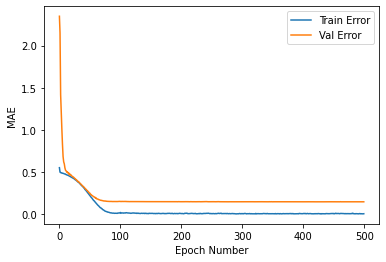

In [11]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig('loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Train Error', 'Val Error'])
plt.xlabel('Epoch Number')
plt.ylabel('MAE')
# plt.ylim(0, 1)
plt.savefig('error_curve.png')
plt.show()

In [12]:
test_x[0].shape
test_sample=torch.unsqueeze(test_x[0],0).to(device)

In [24]:
result=model(test_sample)
result

tensor([[[[0.5631, 0.1613, 0.2831, 0.1240, 0.8366, 0.5690, 0.7362, 0.4886],
          [0.0742, 0.9606, 0.4491, 0.4479, 0.6530, 0.5563, 0.1661, 0.4700],
          [0.5010, 0.6659, 0.5144, 0.3786, 0.7997, 0.0676, 0.6715, 0.7638],
          [0.0919, 0.0576, 0.5811, 0.3686, 0.8451, 0.2421, 0.0748, 0.8471],
          [0.6665, 0.0609, 0.0922, 0.0808, 0.6040, 0.8294, 0.3668, 0.0388],
          [0.8125, 0.7152, 0.5228, 0.8383, 0.3344, 0.7030, 0.4074, 0.5135],
          [0.6818, 0.2215, 0.6831, 0.5449, 0.5332, 0.6988, 0.5042, 0.5323],
          [0.2559, 0.6910, 0.2404, 0.8101, 0.6730, 0.6057, 0.1841, 0.7367]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)

In [26]:
result_sample=torch.unsqueeze(test_y[0],0).to(device)

In [27]:
result_sample

tensor([[[[0.6125, 0.1979, 0.2406, 0.1793, 0.8570, 0.5676, 0.6852, 0.4797],
          [0.0252, 0.9620, 0.4662, 0.4342, 0.5943, 0.5465, 0.0063, 0.4676],
          [0.3534, 0.7350, 0.4841, 0.4371, 0.8043, 0.1661, 0.6479, 0.6845],
          [0.0677, 0.0090, 0.5210, 0.4059, 0.7147, 0.2345, 0.0966, 0.7759],
          [0.5437, 0.2324, 0.0677, 0.1109, 0.7154, 0.7373, 0.4614, 0.0300],
          [0.8700, 0.7075, 0.4881, 0.9723, 0.4534, 0.6483, 0.3494, 0.5438],
          [0.6012, 0.1513, 0.7136, 0.3365, 0.5521, 0.9445, 0.4872, 0.5929],
          [0.2073, 0.6932, 0.2435, 0.9906, 0.8046, 0.4374, 0.2315, 0.7283]]]],
       device='cuda:0')

In [28]:
result_sample-result

tensor([[[[ 0.0495,  0.0366, -0.0426,  0.0553,  0.0203, -0.0014, -0.0511,
           -0.0089],
          [-0.0490,  0.0014,  0.0172, -0.0137, -0.0586, -0.0098, -0.1598,
           -0.0024],
          [-0.1476,  0.0691, -0.0304,  0.0585,  0.0046,  0.0985, -0.0235,
           -0.0793],
          [-0.0242, -0.0486, -0.0601,  0.0373, -0.1304, -0.0076,  0.0218,
           -0.0712],
          [-0.1228,  0.1716, -0.0245,  0.0301,  0.1114, -0.0922,  0.0946,
           -0.0089],
          [ 0.0575, -0.0077, -0.0346,  0.1340,  0.1190, -0.0547, -0.0580,
            0.0302],
          [-0.0806, -0.0702,  0.0305, -0.2084,  0.0189,  0.2457, -0.0170,
            0.0606],
          [-0.0486,  0.0022,  0.0031,  0.1805,  0.1316, -0.1683,  0.0474,
           -0.0084]]]], device='cuda:0', grad_fn=<SubBackward0>)

In [29]:
history[-1]

array([9.16668803e-05, 1.10731925e-02, 7.42801220e-03, 7.17941964e-02])